<a href="https://colab.research.google.com/github/farkoo/Cat-Dog-Classifier/blob/master/CI_HW3_CatDogClassifier_Part_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data preprocessing

In [3]:
%cd drive/MyDrive

/content/drive/MyDrive


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%%bash
git clone "https://github.com/MKasaei00/IUT-CI-HW3-cat-dog-classifier.git"

Cloning into 'IUT-CI-HW3-cat-dog-classifier'...
Checking out files: 100% (13/13), done.


In [4]:
%cd IUT-CI-HW3-cat-dog-classifier

/content/drive/MyDrive/IUT-CI-HW3-cat-dog-classifier


In [ ]:
%%bash
7z x dataset/test_set.zip -odataset
7z x dataset/training_set.zip -odataset

In [5]:
import numpy as np
import os
import cv2
from google.colab.patches import cv2_imshow
from keras.utils import np_utils
import matplotlib.pyplot as plt
import tensorflow as tf
import random
import math

In [5]:
test_dir = 'dataset/test_set'
training_dir = 'dataset/training_set'

In [6]:
def load_data_from_directory(dir,width,height,classes):
  img_data = []
  img_label = []
  counter = 0
  categories = os.listdir(dir)
  for category in categories:
    for file in os.listdir(os.path.join(dir,category)):
      img_path = os.path.join(dir,category,file)
      img = cv2.imread(img_path)
      if counter%5 == 0:
        # Make the images bluer and add to the previous images
        red_channel = (img[:,:,0]/1.5) + 80
        green_channel = (img[:,:,1]/1.5) + 30
        blue_channel = (img[:,:,2]/1.5)
        img2 = img
        img2[:,:,0] = red_channel
        img2[:,:,1] = green_channel
        img2[:,:,2] = blue_channel
        img2 = cv2.resize(img2,(width,height))
        img2 = np.array(img2).astype('float32') / 255
        img_data.append(img2)
        img_label.append(category)

      img = cv2.resize(img,(width,height))
      img = np.array(img).astype('float32') / 255
      
      img_data.append(img)
      img_label.append(category)
      counter = counter + 1

  img_onehot = np_utils.to_categorical([categories.index(label) for label in img_label],classes,dtype=np.ubyte)
  img_data = np.array(img_data)
  img_onehot = np.array(img_onehot)

  zip_list = list(zip(img_data, img_label, img_onehot))
  random.shuffle(zip_list)
  img_data, img_label, img_onehot = zip(*zip_list)
  return img_data , img_label, img_onehot

In [6]:
classes = 2
w = 128
h = 128

In [9]:
train_x , train_label, train_onehot = load_data_from_directory(training_dir,w,h,classes)
test_x , test_label, test_onehot = load_data_from_directory(test_dir,w,h,classes)

In [10]:
test_label2 = []
for i, label in enumerate(test_label):
     test_label2.append(1) if (label == 'dogs') else test_label2.append(0)

In [11]:
train_x = np.asarray(train_x)
train_label = np.asarray(train_label)
train_onehot = np.asarray(train_onehot)

test_x = np.asarray(test_x)
test_label = np.asarray(test_label2)
test_onehot = np.asarray(test_onehot)

In [12]:
!rm -rf cleanData
!mkdir cleanData
np.save('cleanData/train_x.npy',train_x)
np.save('cleanData/train_label.npy',train_label)
np.save('cleanData/train_onehot.npy',train_onehot)

np.save('cleanData/test_x.npy',test_x)
np.save('cleanData/test_label.npy',test_label)
np.save('cleanData/test_onehot.npy',test_onehot)

In [7]:
train_label = np.load('cleanData/train_onehot.npy')
train_x = np.load('cleanData/train_x.npy')

test_x = np.load('cleanData/test_x.npy')
test_label = np.load('cleanData/test_onehot.npy')
test_vec = np.load('cleanData/test_label.npy')

In [8]:
from sklearn.model_selection import train_test_split
train_X, valid_X, train_Label, valid_Label = train_test_split(train_x, train_label, test_size = 0.2, random_state = 13)

# Transfer learning of InceptionV3

In [15]:
from keras.applications.inception_v3 import InceptionV3
from keras.models import Model
from keras.layers import *
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator

In [56]:
def train_model(config):
  input = Input((None, None, 3))
  net = InceptionV3(include_top = False, weights = 'imagenet')(input)
  net = Conv2D(2, 1)(net)
  net = GlobalAveragePooling2D()(net)
  output = Activation('softmax')(net)

  model = Model(inputs = input, outputs = output)
  model.layers[1].trainable=False
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

  train_datagen = ImageDataGenerator(
        rotation_range=config['aug_rotation'],
        width_shift_range=config['aug_shift_w'],
        height_shift_range=config['aug_shift_h'],
        shear_range=config['aug_shear'],
        zoom_range=config['aug_zoom'],
        horizontal_flip=config['aug_horizontal_flip'],
        fill_mode='nearest'
  )

  train_generator = train_datagen.flow(train_X, train_Label, batch_size = config['batch'])

  validation_datagen = ImageDataGenerator()
  validation_generator = validation_datagen.flow(valid_X,valid_Label,batch_size=256)

  history = model.fit(train_generator,
                                validation_data=validation_generator,
                                epochs = config['epochs'],
                                batch_size=config['batch'],
                                steps_per_epoch=math.ceil(7680/config['batch']),
                                validation_steps = math.ceil(1920/config['batch'])
                                )
  
  plt.plot(history.history['acc'])
  plt.plot(history.history['val_acc'])
  plt.title('Model Accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train','validation'],loc='lower right')
  plt.show()

  test_eval = model.evaluate(test_x, test_label, verbose = 0)
  print('Test loss: ', test_eval[0])
  print('Test accuracy: ', test_eval[1])
  print('\n\n')
  
  predictes_classes = model.predict(test_x)
  predicted_classes = np.argmax(np.round(predictes_classes), axis = 1)

  from sklearn.metrics import classification_report
  target_names = ["Class {}".format(i) for i in range(classes)]
  print(classification_report(test_vec, predicted_classes, target_names = target_names))

  return model

Epoch 1/10
30/30 [==============================] - 44s 1s/step - loss: 1.6110 - acc: 0.5827 - val_loss: 0.3501 - val_acc: 0.8677
Epoch 2/10
30/30 [==============================] - 24s 815ms/step - loss: 0.5201 - acc: 0.7927 - val_loss: 0.2876 - val_acc: 0.8880
Epoch 3/10
30/30 [==============================] - 24s 813ms/step - loss: 0.4278 - acc: 0.8237 - val_loss: 0.2665 - val_acc: 0.8948
Epoch 4/10
30/30 [==============================] - 24s 811ms/step - loss: 0.4068 - acc: 0.8327 - val_loss: 0.2675 - val_acc: 0.8927
Epoch 5/10
30/30 [==============================] - 24s 814ms/step - loss: 0.3610 - acc: 0.8433 - val_loss: 0.2559 - val_acc: 0.8958
Epoch 6/10
30/30 [==============================] - 24s 815ms/step - loss: 0.3627 - acc: 0.8532 - val_loss: 0.2334 - val_acc: 0.8984
Epoch 7/10
30/30 [==============================] - 24s 818ms/step - loss: 0.3229 - acc: 0.8608 - val_loss: 0.2376 - val_acc: 0.9005
Epoch 8/10
30/30 [==============================] - 24s 815ms/step - los

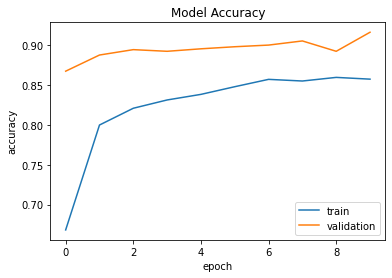

Test loss:  0.18886986374855042
Test accuracy:  0.9325000047683716



              precision    recall  f1-score   support

     Class 0       0.94      0.93      0.93      1200
     Class 1       0.93      0.94      0.93      1200

    accuracy                           0.93      2400
   macro avg       0.93      0.93      0.93      2400
weighted avg       0.93      0.93      0.93      2400



In [68]:
model = train_model({
    'in_drop_out':0,
    'batch':256,
    'epochs':10,
    'aug_rotation':60,
    'aug_shift_w':0.08,
    'aug_shift_h':0.08,
    'aug_shear':0.08,
    'aug_zoom':0.08,
    'aug_horizontal_flip':True
})